In [1]:
source('libraries.R')
source('hla_functions.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘arrow’


The following obje

In [2]:
plan(sequential)

In [4]:
plan(multicore, workers = 6)

In [3]:
source('cdr3-QTL_functions.R')

In [4]:
hla_genotypes_matrix <- fread('../data/hla/hla_genotypes_matrix_wo_low_ab.csv')

In [5]:
hla_random <- fread('../data/hla/hla_genotypes_random.csv')

In [5]:
pca_matrix_list <- list()

for (pcs in seq(1,16)){
    for (cor_cutoff in seq(0.3, 1, by = .1)){
        test_name <- paste0(pcs, '_', cor_cutoff)
        
        pca_matrix <- as.data.table(pca_hla_fun(hla_genotypes_matrix, cor_cutoff, pcs))

        pca_matrix_random <- as.data.table(pca_hla_fun(hla_random, cor_cutoff, pcs))
        setnames(pca_matrix_random, old = names(pca_matrix_random[,-1]), new = gsub("PC", "random", names(pca_matrix_random[,-1])))
        
        pca_both <- merge(pca_matrix, pca_matrix_random)
        pca_both$test_name <- test_name
        fwrite(pca_both, paste0('../PCA_experiment/', test_name, '.csv'))
        pca_matrix_list[[test_name]] <- pca_both
        
        
    }
}

In [6]:
cdr3_hla_matrix <- fread('../cdr3_hla_pairs/irt_freq_unique/DRB1_13_13_P109_matrix.tsv')
cdr3_hla_matrix <- cdr3_hla_matrix[, !grep("PC", colnames(cdr3_hla_matrix)), with = FALSE]

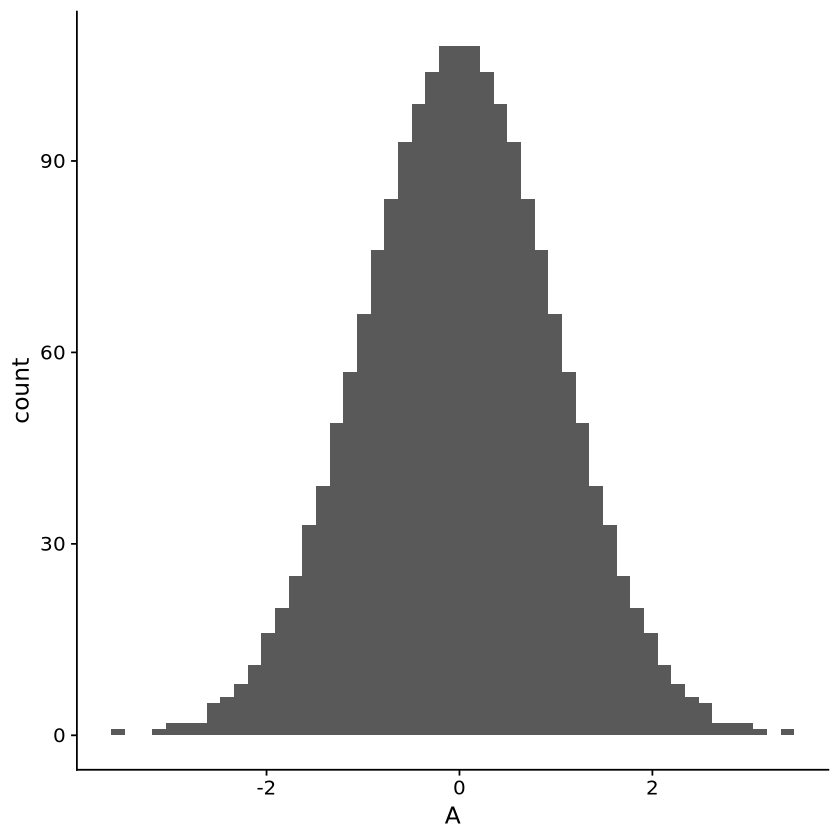

In [7]:
ggplot(cdr3_hla_matrix, aes(A)) +
geom_histogram(bins = 50) +
theme_cowplot()

In [7]:
pca_matrix <- fread('../PCA_experiment//3_0.5.csv')

In [8]:
cdr3_hla_pca_matrix <- merge(cdr3_hla_matrix, pca_matrix, by = 'patient_id')

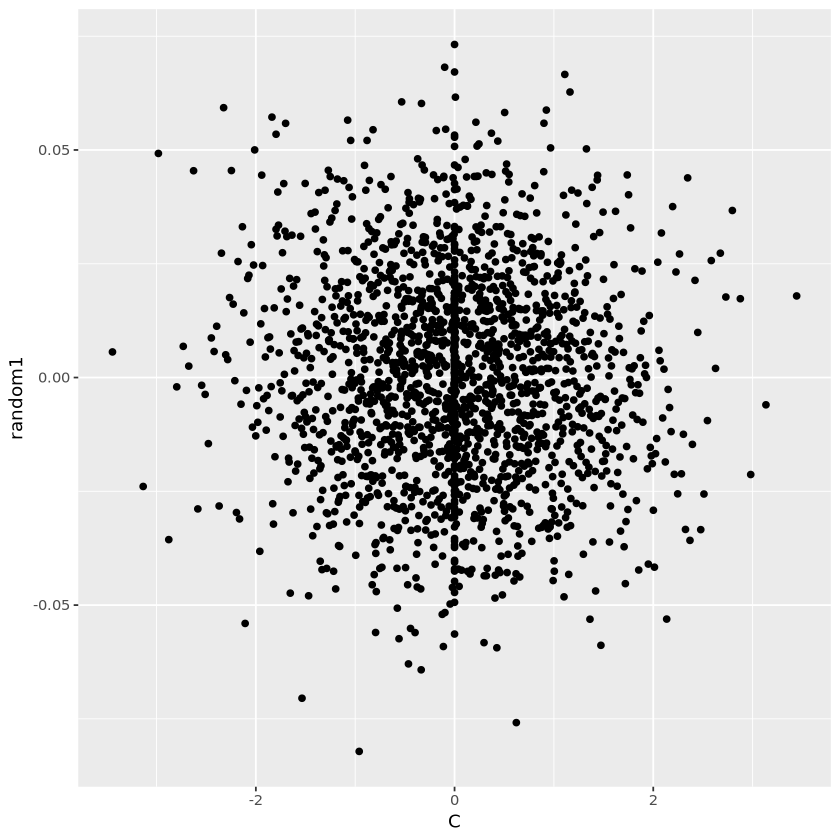

In [10]:
ggplot(cdr3_hla_pca_matrix, aes(C, random1)) + 
geom_point()

In [9]:
train <- cdr3_hla_pca_matrix[sample(.N, 1500)]
validation <- setdiff(cdr3_hla_pca_matrix, train)

In [10]:
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 

hla_alleles <- cdr3_hla_matrix %>% summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% arrange(desc(V1)) %>% slice(-1) %>% rownames()
aa_in_matrix <- colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids]
predictors <- paste(hla_alleles, collapse = "+")
components <- paste(colnames(train)[grep('PC',colnames(train))], collapse = "+")
random_components <- paste(colnames(train)[grep('random',colnames(train))], collapse = "+")

In [11]:
var_list <- c()
for (aa in aa_in_matrix){
    var_name <- paste0(aa, '_full')
    var_list <- c(var_list, var_name)
    formula_full_aa <- paste0(aa, '~', predictors, '+', components)
    assign(var_name, bf(formula_full_aa, family = student()))
}
combined_full <- map(var_list, function(x) get(x))
formula_full_dyn <- bf(as.formula(paste0('mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y )', '~', predictors, '+', components)), family = student())  

In [13]:
formula_full <- bf(mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y) ~ allele_H + allele_R + allele_Y + allele_F + allele_G + PC1 + PC2 + PC3) + set_rescor(TRUE)
formula_null <- bf(mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y) ~ PC1 + PC2 + PC3) + set_rescor(TRUE)
formula_random <- bf(mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y) ~ random1 + random2 + random3) + set_rescor(TRUE)

In [14]:
plan(multisession, workers = 10)

In [15]:
full_model <- brm(formula_full,  
                  data = train, 
                  control = list(max_treedepth = 20), iter = 4000, future = TRUE )
null_model <- brm(formula_null,  
                  data = train, 
                  control = list(max_treedepth = 20), iter = 4000, future = TRUE )
random_model <- brm(formula_random,  
                  data = train, 
                  control = list(max_treedepth = 20), iter = 4000, future = TRUE)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.008947 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 89.47 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 944.364 seconds (Warm-up)
Chain 1:                769.115 seconds (Sampling)
Chain 1:              

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.005185 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 51.85 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 904.299 seconds (Warm-up)
Chain 1:                657.002 seconds (Sampling)
Chain 1:              

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.005056 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 50.56 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 624.676 seconds (Warm-up)
Chain 1:                394.715 seconds (Sampling)
Chain 1:              

In [ ]:
formula_mean <- bf(mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y) ~ 1) + set_rescor(TRUE)
mean_model <- brm(formula_mean,  
                  data = train, 
                  control = list(max_treedepth = 20), iter = 4000, future = TRUE)
saveRDS(mean_model, file = "mean_model.rds")
loo_mean <- loo(mean_model)
full_model <- readRDS("full_model.rds")
loo_compare(full_model, mean_model)

Compiling Stan program...

Start sampling



In [ ]:
mean_model

In [ ]:
loo_compare(full_model, mean_model)

In [16]:
fit_full <- add_criterion(full_model, "loo")
summary(fit_full)
bayes_R2(fit_full)

fit_null <- add_criterion(null_model, "loo")
summary(fit_null)
bayes_R2(fit_null)

fit_random <- add_criterion(random_model, "loo")
summary(fit_random)
bayes_R2(fit_random)


Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'full_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


 Family: MV(gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
        

,Estimate,Est.Error,Q2.5,Q97.5
R2A,0.10117634,0.013541541,0.075838668,0.12865148
R2C,0.01577226,0.005771992,0.006076715,0.02879358
R2D,0.15255068,0.015496368,0.122436630,0.18349255
R2E,0.18982087,0.016404476,0.158572118,0.22213120
R2F,0.05833513,0.011076180,0.037382826,0.08088609
R2G,0.07399371,0.012204000,0.050956604,0.09825875
R2H,0.10124812,0.014236184,0.074169468,0.13001122
R2I,0.12619814,0.014790670,0.098144961,0.15603166
R2K,0.49118298,0.013062356,0.464588467,0.51600479
R2L,0.11019426,0.014134892,0.084162079,0.13874711


Warning message:
“Found 7 observations with a pareto_k > 0.7 in model 'null_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


 Family: MV(gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
        

,Estimate,Est.Error,Q2.5,Q97.5
R2A,0.021502488,0.007180006,0.0091840680,0.037051194
R2C,0.006585710,0.003799647,0.0010447267,0.015632860
R2D,0.060791874,0.011489664,0.0394406453,0.084700945
R2E,0.011776818,0.005220411,0.0033785834,0.023347073
R2F,0.008651070,0.004448594,0.0017836923,0.018755057
R2G,0.036899726,0.009245584,0.0206302204,0.056650461
R2H,0.023046988,0.007310910,0.0104708680,0.038844505
R2I,0.018924938,0.006647970,0.0074769961,0.033422600
R2K,0.025804065,0.007846630,0.0121404207,0.042889052
R2L,0.003114019,0.002341464,0.0002506457,0.009080886


Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'random_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


 Family: MV(gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
        

,Estimate,Est.Error,Q2.5,Q97.5
R2A,0.010697883,0.004956221,0.0029723781,0.021950070
R2C,0.005033648,0.003269630,0.0005594681,0.012811488
R2D,0.004979160,0.003236317,0.0005608923,0.012930280
R2E,0.003936023,0.002777328,0.0003707904,0.010964121
R2F,0.006349253,0.003735774,0.0009943472,0.015082203
R2G,0.004632420,0.003066939,0.0004947378,0.011953279
R2H,0.003211912,0.002419969,0.0002381288,0.009421039
R2I,0.005742110,0.003505420,0.0007040767,0.014133923
R2K,0.003253485,0.002480285,0.0002588229,0.009711837
R2L,0.005685659,0.003458317,0.0007608610,0.014171014


In [33]:
bayes_R2(fit_full)

,Estimate,Est.Error,Q2.5,Q97.5
R2A,0.10117634,0.013541541,0.075838668,0.12865148
R2C,0.01577226,0.005771992,0.006076715,0.02879358
R2D,0.15255068,0.015496368,0.122436630,0.18349255
R2E,0.18982087,0.016404476,0.158572118,0.22213120
R2F,0.05833513,0.011076180,0.037382826,0.08088609
R2G,0.07399371,0.012204000,0.050956604,0.09825875
R2H,0.10124812,0.014236184,0.074169468,0.13001122
R2I,0.12619814,0.014790670,0.098144961,0.15603166
R2K,0.49118298,0.013062356,0.464588467,0.51600479
R2L,0.11019426,0.014134892,0.084162079,0.13874711


In [34]:
bayes_R2(fit_null)

,Estimate,Est.Error,Q2.5,Q97.5
R2A,0.021502488,0.007180006,0.0091840680,0.037051194
R2C,0.006585710,0.003799647,0.0010447267,0.015632860
R2D,0.060791874,0.011489664,0.0394406453,0.084700945
R2E,0.011776818,0.005220411,0.0033785834,0.023347073
R2F,0.008651070,0.004448594,0.0017836923,0.018755057
R2G,0.036899726,0.009245584,0.0206302204,0.056650461
R2H,0.023046988,0.007310910,0.0104708680,0.038844505
R2I,0.018924938,0.006647970,0.0074769961,0.033422600
R2K,0.025804065,0.007846630,0.0121404207,0.042889052
R2L,0.003114019,0.002341464,0.0002506457,0.009080886


In [18]:
saveRDS(full_model, file = "full_model.rds")
saveRDS(null_model, file = "null_model.rds")
saveRDS(random_model, file = "random_model.rds")

In [25]:
loo_null <- loo(null_model)
loo_full <- loo(full_model)
loo_random <- loo(random_model)

# Compare the two models


Warning message:
“Found 7 observations with a pareto_k > 0.7 in model 'null_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'full_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'random_model'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


In [31]:
loo_compare(loo_random, loo_full)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
full_model,0.000,0.00000,-34530.62,334.4135,494.4396,46.90432,69061.25,668.8271
random_model,-1747.345,55.25648,-36277.97,325.1177,386.0269,41.23335,72555.94,650.2354


In [28]:
ss_res <- var(residuals(full_model))
ss_total <- var(fitted(full_model)) + ss_res
r2 <- 1 - (ss_res/ss_total)
r2

[1] 0.04440126

In [32]:
ss_res <- var(residuals(null_model))
ss_total <- var(fitted(null_model)) + ss_res
r2 <- 1 - (ss_res/ss_total)
r2

[1] 0.006707225

In [37]:
pp_full <- posterior_predict(full_model, newdata = validation)
pp_null <- posterior_predict(null_model, newdata = validation)
pp_random <- posterior_predict(random_model, newdata = validation)

In [36]:
validation

patient_id,allele_F,allele_G,allele_H,allele_R,allele_S,allele_Y,G_S,A,C,⋯,Y,L_P,pair,PC1,PC2,PC3,random1,random2,random3,test_name
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
H105,0,0,0,1,1,0,DRB1_13,-0.834025900,-0.43837523,⋯,0.11830340,13_P109,DRB1_13_13_P109,-0.014618742,3.980108e-02,-0.0168659736,-0.0335725404,-0.0431995853,-0.025834024,3_0.5
H107,0,1,0,0,0,1,DRB1_13,-0.008477252,0.13866035,⋯,0.09469417,13_P109,DRB1_13_13_P109,-0.030305700,-2.762232e-02,-0.0100820467,-0.0049546984,0.0082359722,0.007010196,3_0.5
H108,0,1,1,0,0,0,DRB1_13,-0.571533768,-0.62776930,⋯,0.05284375,13_P109,DRB1_13_13_P109,-0.011982584,1.362039e-02,0.0306683918,0.0235448408,-0.0008524243,-0.021721401,3_0.5
H109,0,0,1,0,1,0,DRB1_13,0.497797993,0.38508787,⋯,0.29301469,13_P109,DRB1_13_13_P109,-0.002070843,-8.329614e-06,0.0014801808,-0.0028285193,-0.0218201697,-0.009240972,3_0.5
H111,0,1,0,0,1,0,DRB1_13,-1.571679176,-0.05906463,⋯,-1.14217354,13_P109,DRB1_13_13_P109,-0.008092825,3.118681e-02,-0.0119776854,-0.0206663074,0.0352259071,-0.005957378,3_0.5
H113,0,0,0,0,2,0,DRB1_13,-1.159879636,-1.72551761,⋯,0.88690496,13_P109,DRB1_13_13_P109,-0.030485253,1.944719e-02,-0.0305228459,-0.0129146321,0.0102839184,0.022950053,3_0.5
H122,0,0,0,0,2,0,DRB1_13,-0.505192671,-1.13960365,⋯,-0.97543519,13_P109,DRB1_13_13_P109,-0.032083383,1.153819e-03,0.0300410296,-0.0157163439,0.0385477723,0.012833800,3_0.5
H124,0,0,0,1,1,0,DRB1_13,-1.072359051,-1.49916385,⋯,-0.49337424,13_P109,DRB1_13_13_P109,-0.026509657,-4.981486e-03,0.0311565894,-0.0085901216,-0.0096889754,0.002445298,3_0.5
H132,1,0,1,0,0,0,DRB1_13,-0.046314838,0.54149315,⋯,-0.32722679,13_P109,DRB1_13_13_P109,-0.019784278,5.052829e-02,0.0166112551,-0.0308498915,0.0448868296,0.055832513,3_0.5


### Visualisation of Bayesian model and its predictions

In [ ]:
tidy_coef <- tidy(stan_model)

# Extract intercept and slope
model_intercept <- tidy_coef$estimate[1]
model_slope <- tidy_coef$estimate[2]

# Create the plot
ggplot(songs, aes(x = song_age, y = popularity)) +
  geom_point() +
  geom_abline(intercept = model_intercept, slope = model_slope)


draws <- spread_draws(stan_model, `(Intercept)`, song_age)

# Save the values from each draw of the posterior distribution
draws <- spread_draws(stan_model, `(Intercept)`, `song_age`)

# Create the plot
ggplot(songs, aes(x = song_age, y = popularity)) +
    geom_point() +
    geom_abline(data = draws, aes(intercept = `(Intercept)`, 
                                  slope = song_age),size = 0.1, alpha = 0.2, color = "skyblue") +
    geom_abline(intercept = model_intercept, slope = model_slope)



new_predictions[1:10, ]

new_predictions <- posterior_predict(stan_model, newdata = predict_data)

# Convert to data frame and rename variables
new_predictions <- as.data.frame(new_predictions)
colnames(new_predictions) <- c("Adele", "Taylor Swift", "Beyoncé")

# Create tidy data structure
plot_posterior <- gather(new_predictions, key = "artist_name", value = "predict")

# Print formated data
head(plot_posterior)

ggplot(plot_posterior, aes(x = predict)) + facet_wrap(~ artist_name, ncol = 1) + geom_density()

In [26]:
pairs(full_model)

In [186]:
var_list <- c()
for (aa in aa_in_matrix){
    var_name <- paste0(aa, '_null')
    var_list <- c(var_list, var_name)
    formula_null_aa <- paste0(aa, '~', components)
    assign(var_name, bf(formula_null_aa, family = student()))
}
combined_null <- map(var_list, function(x) get(x))
formula_null_dyn <- bf(as.formula(paste0('mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y )', '~', components)), 
                   family = gamma())                     

In [ ]:
null_model <- brm(formula_null + set_rescor(TRUE), 
                  family = student(), 
                  data = train)

Compiling Stan program...



In [213]:
for (aa in aa_in_matrix){
    formula_site <- paste0(aa, '~', predictors)
    assign(aa, bf(formula_site, family = student()))
}
combined_site <- map(aa_in_matrix, function(x) get(x))
formula_site <- bf(as.formula(paste0('mvbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y )', '~', predictors)), 
                   family = student())  

In [ ]:
site_model <- brm(formula_site + set_rescor(TRUE), 
                  family = student(), 
                  data = train)

Compiling Stan program...



In [152]:
predictions_from_full <- as.data.table(predict(full_model, newdata = validation_matrix))
predictions_from_null <- as.data.table(predict(null_model, newdata = validation_matrix))


In [188]:
full_model <- brm(combined_full[[1]], family = student(), 
                  data = train)
null_model <- brm(combined_null[[1]], family = student(), 
                  data = train)

Setting 'rescor' to TRUE by default for this model

Warning message:
“In the future, 'rescor' will be set to FALSE by default for all models. It is thus recommended to explicitely set 'rescor' via 'set_rescor' instead of using the default.”
Compiling Stan program...

Start sampling



Error in data_list2array(x) : all elements of the list should be numeric


failed to preprocess the data; sampling not done



In [155]:
colnames(predictions_from_full) <- paste0(colnames(predictions_from_full), '_full')
colnames(predictions_from_null) <- paste0(colnames(predictions_from_null), '_null')

In [157]:
predictions_df <- cbind(predictions_from_full, predictions_from_null)
predictions_df$A_true <- validation_matrix$A

In [ ]:
predictions_df

In [ ]:
ggplot(predictions_df, aes(x = A_true)) +
  geom_point(aes(y = Estimate_full, color = "Alleles + PCs")) +
  geom_point(aes(y = Estimate_null, color = "PCs")) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(x = "True Values", y = "Predicted Values", color = "Model") +
  ylim(min(predictions_df$A_true), max(predictions_df$A_true)) +
  scale_color_viridis_d() +
  theme_cowplot() +
  ggtitle("Comparison of Predicted vs True Values for Both Models")